# Solution template for Assignment 4

This is the template notebook for Assignment 4.

The infrastructure code (vocabulary management, training loop, word embedding loading, evaluation, etc) has been moved into a separate file <code>ner_util.py</code> you can get [here](http://www.cse.chalmers.se/~richajo/dat450/assignments/ner_util.py). Download this file and put it into the same directory as where you are executing your notebook. Import this file and you are ready to go.

In [1]:
!pip install gensim==4.3.2

In [2]:
import ner_util
import torch

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"


In [4]:
"""!rm -f *py *tsv
!wget http://www.cse.chalmers.se/~richajo/dat450/assignments/ner_util.py
#!wget https://github.com/cambridgeltl/MTL-Bioinformatics-2016/blob/master/data/BC5CDR-IOB/train.tsv
#!wget https://github.com/cambridgeltl/MTL-Bioinformatics-2016/blob/master/data/BC5CDR-IOB/devel.tsv

# If you have trouble downloading from github, instead get them from 
!wget http://www.cse.chalmers.se/~richajo/dat450/assignments/a4/train.tsv
!wget http://www.cse.chalmers.se/~richajo/dat450/assignments/a4/devel.tsv"""

'!rm -f *py *tsv\n!wget http://www.cse.chalmers.se/~richajo/dat450/assignments/ner_util.py\n#!wget https://github.com/cambridgeltl/MTL-Bioinformatics-2016/blob/master/data/BC5CDR-IOB/train.tsv\n#!wget https://github.com/cambridgeltl/MTL-Bioinformatics-2016/blob/master/data/BC5CDR-IOB/devel.tsv\n\n# If you have trouble downloading from github, instead get them from \n!wget http://www.cse.chalmers.se/~richajo/dat450/assignments/a4/train.tsv\n!wget http://www.cse.chalmers.se/~richajo/dat450/assignments/a4/devel.tsv'

## Reading the data in a tabular format

The following function reads a file represented in a tabular format. In this format, each row corresponds to one token. For each token, there is a word and the BIO-coded named entity label, separated by whitespace. The sentences are separated by empty lines. Here is an example of a sentence.
```
In              O
conclusion      O
,               O
hyperammonemic  B-Disease
encephalopathy  I-Disease
can             O
occur           O
in              O
patients        O
receiving       O
continuous      O
infusion        O
of              O
5               B-Chemical
-               I-Chemical
FU              I-Chemical
.               O
```
The function `ner_util.read_data` reads the file in this format and returns sentences and their corresponding BIO labels.

In [5]:
Xtrain, Ytrain = ner_util.read_data(r'C:\Users\KG\Documents\GitHub\advent-of-code-2023\work\data\train.tsv')
Xval, Yval = ner_util.read_data(r'C:\Users\KG\Documents\GitHub\advent-of-code-2023\work\data\devel.tsv')

An example:

In [6]:
Xtrain[100]

['High',
 'doses',
 'of',
 'vitamin',
 'D',
 'are',
 'known',
 'to',
 'cause',
 'calcification',
 'of',
 'the',
 'artery',
 'media',
 'in',
 'as',
 'little',
 'as',
 '3',
 'to',
 '4',
 'days',
 '.']

In [7]:
Ytrain[100]

['O',
 'O',
 'O',
 'B-Chemical',
 'I-Chemical',
 'O',
 'O',
 'O',
 'O',
 'B-Disease',
 'I-Disease',
 'I-Disease',
 'I-Disease',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O']

## Baseline sequence labeling model

This is the baseline model. You can expand on this when implementing your solution.

In [8]:
import torch
from torch import nn

class BaselineSequenceModel(nn.Module):
    
    def __init__(self, seq_labeler):
        super().__init__()                
        
        # Here is how you access the NERParameters.
        p = seq_labeler.params
        
        # The model consists of just a word embedding layer and a
        # linear output unit. We use the vocabulary to create the embedding layer.        
        self.word_embedding = seq_labeler.word_voc.make_embedding_layer(finetune=p.finetune_word_emb, 
                                                                        emb_dim=p.word_emb_dim)
        
    

        # The dimensionality of the word embedding model.
        word_emb_dim = self.word_embedding.weight.shape[1]


        hidden_dim = 10
        self.lstm = nn.LSTM(word_emb_dim, hidden_dim, 1, batch_first=True)


        # Output unit.
        self.top_layer = nn.Linear(hidden_dim, seq_labeler.n_labels)
                        
    def forward(self, words):
        # words is a tensor of integer-encoded words, with shape (batch_size, max_sen_length)
                
        # After embedding the words, the shape is (batch_size, max_sen_length, emb_dim). 
        word_repr = self.word_embedding(words)
        


        lstm_out = self.lstm(word_repr)
 
     
        # We predict the BIO label simply by applying a linear model to
        # the word embedding at that position.
        
        # The shape of the output is (batch_size, max_sen_length, n_labels),
        # where n_labels is the size of the output label vocabulary.
    
        return self.top_layer(lstm_out[0])

## Training the system

As usual, we create an object that contains all hyperparameters.

In [9]:
class NERParameters:

    # Random seed, for reproducibility.
    random_seed = 0    
        
    # cuda or cpu
    device = device
                
    # NB: this hyperparameter is only used if we are training the embedding
    # model from scratch.
    word_emb_dim = 128
    
    # Whether or not to fine-tune the word embedding model.
    finetune_word_emb = False

    # Training parameters
    n_epochs = 20
    batch_size = 32    
    learning_rate = 0.005
    weight_decay = 0

    # Word dropout rate.
    word_dropout_prob = 0.0
        
    # Set the following to True to enable character tensors.
    use_characters = False

Now, we are ready to train. When creating the NER system, the first argument should be the hyperparameter container. The second should be a function that builds the neural network; we just use the constructor of the class we defined above.

In [10]:
device

'cuda'

In [11]:

ner_system = ner_util.SequenceLabeler(NERParameters(), BaselineSequenceModel)

ner_system.fit(Xtrain, Ytrain, Xval, Yval)
  



Epoch 1: train loss = 0.8128, val f1: 0.0000, time = 1.0549
Epoch 2: train loss = 0.4515, val f1: 0.0010, time = 0.8674
Epoch 3: train loss = 0.3907, val f1: 0.0459, time = 0.8912
Epoch 4: train loss = 0.3454, val f1: 0.1581, time = 0.8637
Epoch 5: train loss = 0.3152, val f1: 0.2160, time = 0.8572
Epoch 6: train loss = 0.2934, val f1: 0.2774, time = 0.9060
Epoch 7: train loss = 0.2755, val f1: 0.2836, time = 0.8667
Epoch 8: train loss = 0.2614, val f1: 0.3295, time = 1.0097
Epoch 9: train loss = 0.2491, val f1: 0.3582, time = 0.9221
Epoch 10: train loss = 0.2389, val f1: 0.3567, time = 0.8747
Epoch 11: train loss = 0.2307, val f1: 0.3778, time = 0.9378
Epoch 12: train loss = 0.2222, val f1: 0.3782, time = 0.9542
Epoch 13: train loss = 0.2177, val f1: 0.4015, time = 0.8709
Epoch 14: train loss = 0.2106, val f1: 0.4019, time = 0.9002
Epoch 15: train loss = 0.2061, val f1: 0.4024, time = 1.0853
Epoch 16: train loss = 0.2000, val f1: 0.4138, time = 0.8873
Epoch 17: train loss = 0.1969, va

0.4394315089204717

Optionally, plot the training loss and validation F-score over the epochs.

Text(0.5, 1.0, 'Validation F-score')

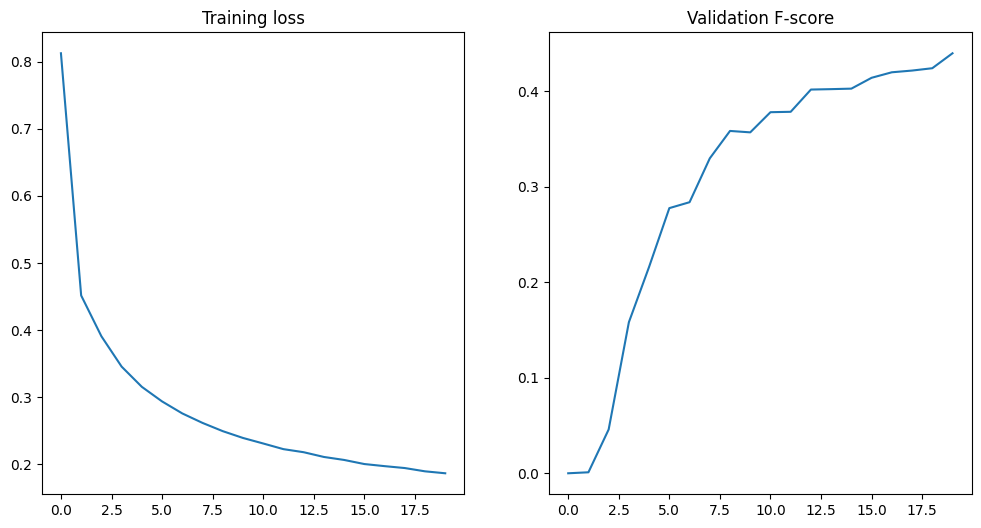

In [13]:
import matplotlib.pyplot as plt

#%config InlineBackend.figure_format = 'retina' 
#plt.style.use('seaborn')

fig, ax = plt.subplots(1, 2, figsize=(2*6,1*6))
ax[0].plot(ner_system.history['train_loss']);
ax[0].set_title('Training loss')
ax[1].plot(ner_system.history['val_f1']);
ax[1].set_title('Validation F-score')

Predicting outputs:

In [14]:
ner_system.predict(['The patient suffered from bubonic plague and COVID-19 .'.split()])

[['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']]

In [15]:
ner_util.show_entities(ner_system, ['The patient suffered from bubonic plague and COVID-19 .'.split()])

In [16]:
def helperfunc(model, num_runs=5):
    """
    Run a given algorithm multiple times with different random seeds.

    Parameters:
    - algorithm_function: The function representing the algorithm to be run.
                         It should take no arguments and return some results.
    - num_runs: Number of times to run the algorithm.

    Returns:
    - results: A list containing the results of each run.
    """
    results = []

    for run in range(num_runs):
        # Set a random seed for PyTorch
        seed = np.random.randint(1, 10000)
        torch.manual_seed(seed)
        
        run_result = model.fit(Xtrain, Ytrain, Xval, Yval)
        results.append(run_result)

    return sum(results) / len(results)

In [17]:
import numpy as np

In [18]:
ner_system = ner_util.SequenceLabeler(NERParameters(), BaselineSequenceModel)
        
normal_mean = helperfunc(ner_system)
normal_mean

Epoch 1: train loss = 0.8128, val f1: 0.0000, time = 0.8896
Epoch 2: train loss = 0.4515, val f1: 0.0010, time = 1.0630
Epoch 3: train loss = 0.3907, val f1: 0.0459, time = 1.0215
Epoch 4: train loss = 0.3454, val f1: 0.1581, time = 0.9506
Epoch 5: train loss = 0.3152, val f1: 0.2160, time = 0.8524
Epoch 6: train loss = 0.2934, val f1: 0.2774, time = 0.9179
Epoch 7: train loss = 0.2755, val f1: 0.2836, time = 0.9939
Epoch 8: train loss = 0.2614, val f1: 0.3295, time = 0.9574
Epoch 9: train loss = 0.2491, val f1: 0.3582, time = 0.9823
Epoch 10: train loss = 0.2389, val f1: 0.3567, time = 0.9446
Epoch 11: train loss = 0.2307, val f1: 0.3778, time = 0.9645
Epoch 12: train loss = 0.2222, val f1: 0.3782, time = 1.0127
Epoch 13: train loss = 0.2177, val f1: 0.4015, time = 0.9722
Epoch 14: train loss = 0.2106, val f1: 0.4019, time = 0.8646
Epoch 15: train loss = 0.2061, val f1: 0.4024, time = 0.9136
Epoch 16: train loss = 0.2000, val f1: 0.4138, time = 0.9766
Epoch 17: train loss = 0.1969, va

0.4394315089204717

In [19]:
para = NERParameters()
para.finetune_word_emb = True
ner_system = ner_util.SequenceLabeler(para, BaselineSequenceModel)
        
finetune_mean = helperfunc(ner_system)

Epoch 1: train loss = 0.7522, val f1: 0.0015, time = 1.3801
Epoch 2: train loss = 0.3211, val f1: 0.4097, time = 1.1412
Epoch 3: train loss = 0.2025, val f1: 0.5546, time = 1.1151
Epoch 4: train loss = 0.1443, val f1: 0.5802, time = 1.0572
Epoch 5: train loss = 0.1109, val f1: 0.5985, time = 1.1292
Epoch 6: train loss = 0.0915, val f1: 0.6138, time = 1.2075
Epoch 7: train loss = 0.0766, val f1: 0.6198, time = 1.2012
Epoch 8: train loss = 0.0662, val f1: 0.6222, time = 1.1417
Epoch 9: train loss = 0.0585, val f1: 0.6243, time = 1.1213
Epoch 10: train loss = 0.0526, val f1: 0.6235, time = 1.1097
Epoch 11: train loss = 0.0479, val f1: 0.6284, time = 1.0483
Epoch 12: train loss = 0.0432, val f1: 0.6295, time = 1.1380
Epoch 13: train loss = 0.0397, val f1: 0.6292, time = 1.0958
Epoch 14: train loss = 0.0374, val f1: 0.6241, time = 1.0302
Epoch 15: train loss = 0.0347, val f1: 0.6279, time = 1.1008
Epoch 16: train loss = 0.0318, val f1: 0.6236, time = 1.0709
Epoch 17: train loss = 0.0297, va

In [25]:
finetune_mean

0.6300607574811198

In [20]:
emb_model = ner_util.load_gensim_vectors(model_file='glove-wiki-gigaword-100', builtin=True)

[==================================================] 100.0% 128.1/128.1MB downloaded
 done!


In [21]:
emb_model[0]

tensor([[-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        [-0.1077,  0.1105,  0.5981,  ..., -0.8316,  0.4529,  0.0826],
        [-0.3398,  0.2094,  0.4635,  ..., -0.2339,  0.4730, -0.0288],
        ...,
        [ 0.3609, -0.1692, -0.3270,  ...,  0.2714, -0.2919,  0.1611],
        [-0.1046, -0.5047, -0.4933,  ...,  0.4253, -0.5125, -0.1705],
        [ 0.2837, -0.6263, -0.4435,  ...,  0.4368, -0.8261, -0.1570]])

In [22]:
ner_system = ner_util.SequenceLabeler(NERParameters(), BaselineSequenceModel,
pretrained_word_emb  = emb_model)
        
pre_mean = helperfunc(ner_system)
pre_mean

Epoch 1: train loss = 0.6076, val f1: 0.1458, time = 0.9325
Epoch 2: train loss = 0.3242, val f1: 0.5004, time = 0.9057
Epoch 3: train loss = 0.2603, val f1: 0.5350, time = 0.8916
Epoch 4: train loss = 0.2291, val f1: 0.5816, time = 0.9036
Epoch 5: train loss = 0.2060, val f1: 0.5990, time = 0.9545
Epoch 6: train loss = 0.1893, val f1: 0.6266, time = 0.8846
Epoch 7: train loss = 0.1778, val f1: 0.6369, time = 0.9409
Epoch 8: train loss = 0.1694, val f1: 0.6379, time = 1.0152
Epoch 9: train loss = 0.1622, val f1: 0.6390, time = 0.9133
Epoch 10: train loss = 0.1574, val f1: 0.6257, time = 0.8877
Epoch 11: train loss = 0.1528, val f1: 0.6394, time = 0.9526
Epoch 12: train loss = 0.1478, val f1: 0.6409, time = 0.9369
Epoch 13: train loss = 0.1444, val f1: 0.6466, time = 0.8819
Epoch 14: train loss = 0.1405, val f1: 0.6512, time = 0.9826
Epoch 15: train loss = 0.1372, val f1: 0.6569, time = 0.8899
Epoch 16: train loss = 0.1349, val f1: 0.6574, time = 0.8913
Epoch 17: train loss = 0.1320, va

0.6596864039612131

In [24]:
emb_model = ner_util.load_gensim_vectors(model_file=r'C:\Users\KG\Documents\GitHub\advent-of-code-2023\PubMed-and-PMC-w2v.bin')
ner_system = ner_util.SequenceLabeler(NERParameters(), BaselineSequenceModel,
pretrained_word_emb  = emb_model)
        
big_pre_mean = helperfunc(ner_system)
big_pre_mean 

Loading model 'C:\Users\KG\Documents\GitHub\advent-of-code-2023\PubMed-and-PMC-w2v.bin' via gensim... done!
Epoch 1: train loss = 0.7007, val f1: 0.4883, time = 0.8774
Epoch 2: train loss = 0.2935, val f1: 0.6464, time = 0.9145
Epoch 3: train loss = 0.2129, val f1: 0.6656, time = 0.9665
Epoch 4: train loss = 0.1749, val f1: 0.7017, time = 0.9070
Epoch 5: train loss = 0.1527, val f1: 0.7160, time = 1.0152
Epoch 6: train loss = 0.1378, val f1: 0.7234, time = 0.9755
Epoch 7: train loss = 0.1272, val f1: 0.7391, time = 0.8932
Epoch 8: train loss = 0.1190, val f1: 0.7386, time = 0.9700
Epoch 9: train loss = 0.1121, val f1: 0.7441, time = 1.0899
Epoch 10: train loss = 0.1057, val f1: 0.7489, time = 0.9763
Epoch 11: train loss = 0.1003, val f1: 0.7460, time = 0.9220
Epoch 12: train loss = 0.0957, val f1: 0.7511, time = 1.0060
Epoch 13: train loss = 0.0923, val f1: 0.7576, time = 0.9903
Epoch 14: train loss = 0.0889, val f1: 0.7533, time = 0.9157
Epoch 15: train loss = 0.0860, val f1: 0.7555, 

0.7642644911114468

We concloude that fine tuning will increase the f score. However, using pretrained embedings could prove to be an equaly improvment or even more, without any additional traning needed.